# Ticket 1.4.1: Correlation Matrix and Hierarchical Clustering

### Objective
Compute correlation coefficients for all encoded features to detect relationships, potential multicollinearity, and natural groupings among variables.

### Steps Performed

1. **Data Loading**
   * Loaded the processed feature datasets:
     * `data/processed/training_encoded.csv`
     * `data/processed/test_encoded.csv`
   * Loaded label data: `data/raw/training_set_labels.csv`.

2. **Feature Selection**
   * Removed the non-predictive identifier column `respondent_id`.
   * Used only numeric columns from `train_encoded`.

3. **Correlation Computation**
   * Calculated the **Pearson correlation matrix**, appropriate because all features are numeric after encoding.
   * Used absolute correlation values to assess feature similarity independent of sign.

4. **Hierarchical Clustering & Visualization**
   * Converted correlations to distances (`1 – |r|`).
   * Applied **Ward linkage** to group highly correlated variables.
   * Plotted a **Seaborn clustermap** with hierarchical clustering to visualize correlation patterns and feature clusters.
   * Adjusted figure size and label spacing to ensure all feature names are fully visible.
   * Saved the resulting figure to:
     ```
     reports/figures/correlation_heatmap_clustered.png
     ```

Train encoded shape: (26707, 55)
Test encoded shape:  (26708, 55)
Labels shape:        (26707, 3)
Correlation matrix shape: (54, 54)


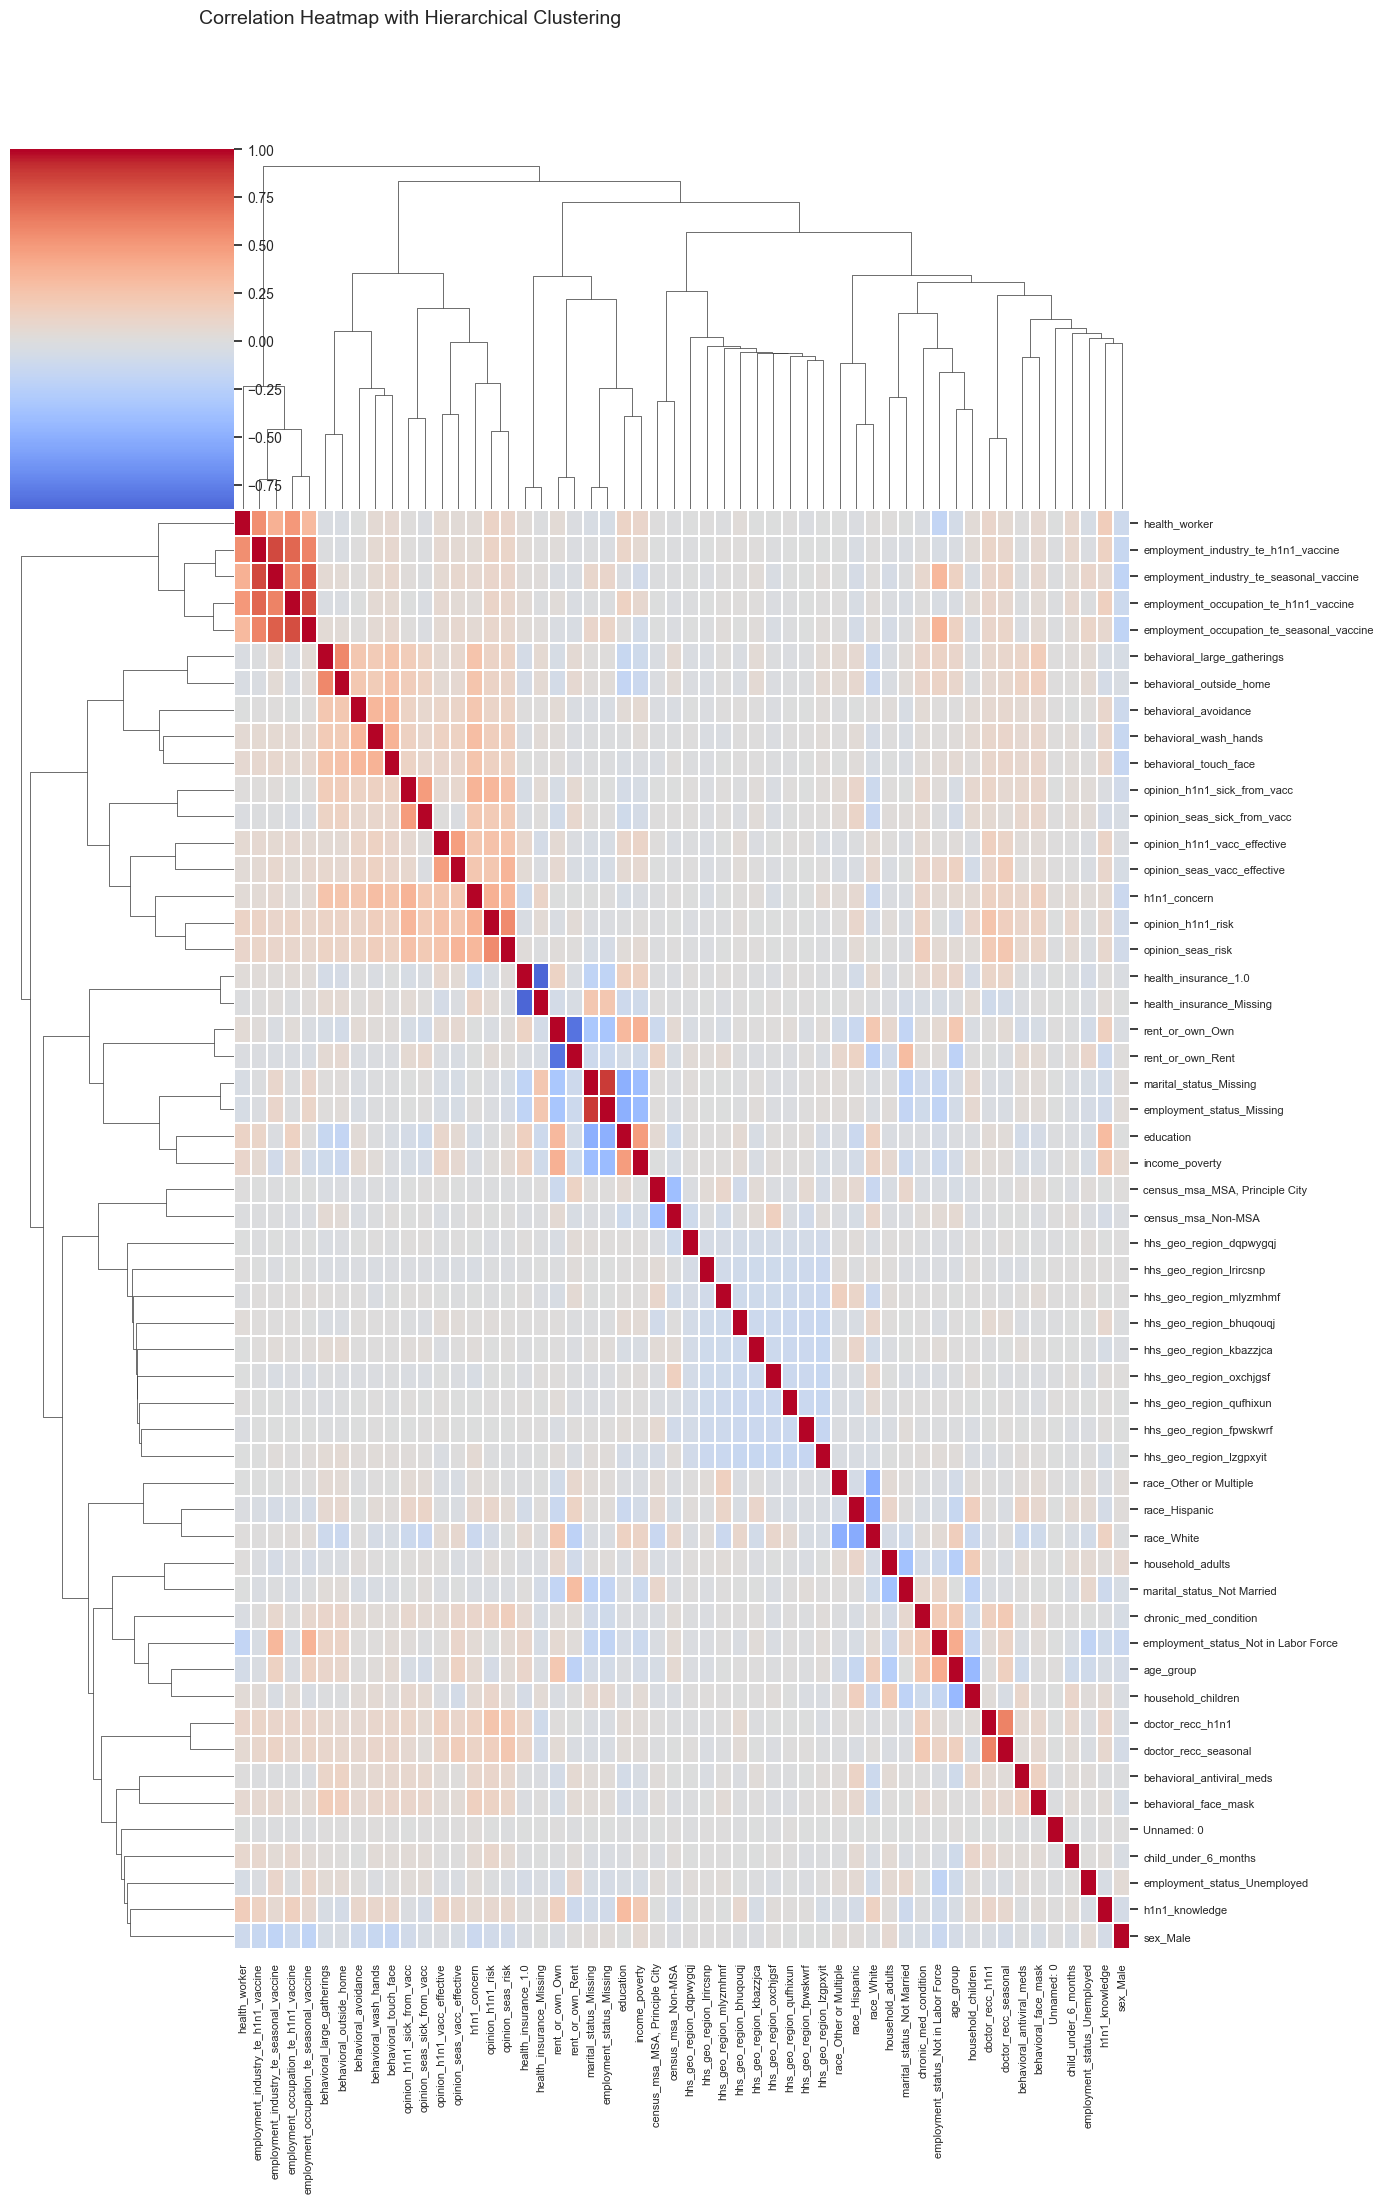

✅ Correlation heatmap saved to: reports\figures\correlation_heatmap_clustered.png


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from pathlib import Path

# --- 1. Load processed and label datasets ---
ROOT = Path.cwd().parent
DATA = ROOT / "data"

train_encoded = pd.read_csv(DATA / "processed" / "training_encoded.csv")
test_encoded  = pd.read_csv(DATA / "processed" / "test_encoded.csv")
train_labels  = pd.read_csv(DATA / "raw" / "training_set_labels.csv")

print(f"Train encoded shape: {train_encoded.shape}")
print(f"Test encoded shape:  {test_encoded.shape}")
print(f"Labels shape:        {train_labels.shape}")

# --- 2. Drop ID and compute correlation matrix ---
df_corr = train_encoded.drop(columns=["respondent_id"], errors="ignore")
corr_matrix = df_corr.corr(method="pearson")

print("Correlation matrix shape:", corr_matrix.shape)

# --- 3. Hierarchical clustering heatmap ---
sns.set(style="white", font_scale=0.9)

pairwise_dists = 1 - np.abs(corr_matrix)
linkage = hierarchy.linkage(squareform(pairwise_dists), method="ward")

g = sns.clustermap(
    corr_matrix,
    row_linkage=linkage,
    col_linkage=linkage,
    cmap="coolwarm",
    linewidths=0.2,
    figsize=(16, 20),
    center=0,
)

# Improve label readability
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=8)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=8)

# Add title and adjust layout directly on the clustermap figure
g.fig.suptitle("Correlation Heatmap with Hierarchical Clustering", fontsize=14, y=1.02)
g.fig.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)

# --- 4. Save figure to reports/figures ---
FIG_DIR = ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
fig_path = FIG_DIR / "correlation_heatmap_clustered.png"

# Save *and* show the same figure
g.fig.savefig(fig_path, bbox_inches="tight", dpi=300)

# Display in notebook
plt.show(g.fig)

# Print relative path
relative_path = fig_path.relative_to(ROOT)
print(f"✅ Correlation heatmap saved to: {relative_path}")

### Key Findings

* Most features show **low to moderate correlations**, suggesting minimal multicollinearity after encoding.
* A few natural groupings appear:
  * **Behavioral** and **opinion** survey responses cluster together.
  * **Target-encoded** features for industry and occupation form their own small cluster.
  * Binary demographic indicators are largely independent.

### Interpretation

* No large blocks of strongly correlated features were observed (|r| > 0.9).
* The feature space is **well-structured and diverse**, supporting downstream modeling without major feature-reduction needs.

### Conclusion

* The correlation analysis confirms good separation among encoded variables.
* Figure `correlation_heatmap_clustered.png` serves as documentation of feature relationships.
* Results feed directly into **Ticket 1.4.2 (Redundant Feature Detection)**.


# Ticket 1.4.2: Identify Potentially Redundant Features


In [11]:
# 1. Compute absolute correlation matrix
corr_abs = corr_matrix.abs()

# 2. Find highly correlated pairs
threshold = 0.8  # adjust as needed

# Keep only upper triangle to avoid duplicates
upper_triangle = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

# Stack into a tidy DataFrame
high_corr_pairs = (
    upper_triangle.stack()
    .reset_index()
    .rename(columns={0: "Correlation", "level_0": "Feature_1", "level_1": "Feature_2"})
)

# Filter by threshold
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"] > threshold] \
    .sort_values(by="Correlation", ascending=False)

print(f"Number of feature pairs with correlation > {threshold}: {len(high_corr_pairs)}")

# 3. Display top correlated pairs
display(high_corr_pairs.head(20))

# 4. Identify redundant candidates
redundant_features = set(high_corr_pairs["Feature_2"].unique())

print(f"\nPotentially redundant features (count={len(redundant_features)}):")
for f in sorted(redundant_features):
    print(f"  - {f}")


Number of feature pairs with correlation > 0.8: 5


,Feature_1,Feature_2,Correlation
1178,health_insurance_1.0,health_insurance_Missing,0.877902
1088,marital_status_Missing,employment_status_Missing,0.876134
1425,employment_industry_te_h1n1_vaccine,employment_industry_te_seasonal_vaccine,0.830442
1131,rent_or_own_Own,rent_or_own_Rent,0.818975
1430,employment_occupation_te_h1n1_vaccine,employment_occupation_te_seasonal_vaccine,0.814283



Potentially redundant features (count=5):
  - employment_industry_te_seasonal_vaccine
  - employment_occupation_te_seasonal_vaccine
  - employment_status_Missing
  - health_insurance_Missing
  - rent_or_own_Rent


##  **Analysis of Correlated Pairs (|r| > 0.8)**

| Pair                                                                                      | Correlation | Interpretation                                                                                                                                                                                                                               | Recommendation                                                                                                                                                                                                          |
| ----------------------------------------------------------------------------------------- | ----------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **`health_insurance_1.0` ↔ `health_insurance_Missing`**                                   | 0.878       | These come from **one-hot encoding** of the same variable (`health_insurance`). When a feature has “1.0” and “Missing” dummies, they will naturally be negatively or positively correlated — because there are only a few possible states.   | ✅ *Keep both* — no issue. This correlation is **expected** in one-hot encoded binary indicators. You can safely leave them as-is, or later drop one dummy per model input (most models handle this automatically).      |
| **`marital_status_Missing` ↔ `employment_status_Missing`**                                | 0.876       | Both represent **missingness in related demographic variables**. People who did not answer “marital_status” often didn’t answer “employment_status” either — likely due to similar survey-skipping patterns.                                 | ⚠️ *Not redundant in content*, but **reflect shared missingness behavior**. Keeping both helps the model detect “missingness patterns”. Don’t drop either yet.                                                          |
| **`employment_industry_te_h1n1_vaccine` ↔ `employment_industry_te_seasonal_vaccine`**     | 0.83        | Both are **target encodings** for the same categorical variable but using **different targets**. Their high correlation just means that people’s vaccination behavior across H1N1 and seasonal vaccines was somewhat consistent by industry. | ✅ *Keep both.* Each is predictive for a different target variable — not redundant but informative.                                                                                                                      |
| **`rent_or_own_Own` ↔ `rent_or_own_Rent`**                                                | 0.819       | Two dummy variables from the same one-hot group (`rent_or_own`). They’re **mutually exclusive and inversely related**, so some correlation is expected.                                                                                      | ⚠️ Slight redundancy, but **not an error** — if you use models sensitive to multicollinearity (like linear/logistic regression), you’ll typically drop one dummy. Tree models (RandomForest, XGBoost) handle this fine. |
| **`employment_occupation_te_h1n1_vaccine` ↔ `employment_occupation_te_seasonal_vaccine`** | 0.814       | Similar to the industry encoding — same categorical source, separate targets.                                                                                                                                                                | ✅ *Keep both.* Encodes distinct target relationships.                                                                                                                                                                   |



##  **Summary and Recommendations**

| Category                                                                | Action                                                                          | Rationale                                                   |
| ----------------------------------------------------------------------- | ------------------------------------------------------------------------------- | ----------------------------------------------------------- |
| **One-hot encoded features** (`health_insurance_*`, `rent_or_own_*`)    | Optionally drop one dummy per category *only* if using regression-based models. | Prevents linear dependency (“dummy variable trap”).         |
| **Missingness indicators**                                              | Keep.                                                                           | Capture nonrandom missing data patterns — often predictive. |
| **Target-encoded pairs** (`*_te_h1n1_vaccine`, `*_te_seasonal_vaccine`) | Keep both.                                                                      | Encode different relationships per target.                  |



###  **Conclusion**

* None of the correlations above indicate **true redundancy** (i.e., duplicate information).
* All high correlations are **expected** given encoding design:

  * Dummy variables are mutually exclusive.
  * Target encodings correlate because behavior is consistent.
  * Missing indicators co-occur logically.

** Recommendation:**
Keep all features as they are. No removal or merging needed at this stage.